**F22-102-R-CardioCheck**

Cardiac Diagnostic Framework 

Abdullah Shakeel (i19-1717)

Ahmed Wadood (i19-1858)

Muhammad Ali (i19-1882)

A deep learning-based cardiac diagnostic framework that supports segmentation of the left ventricle in Cardiac MRI images using UNET and calculation of patient-wise Ejection Fraction.  

In [ ]:
# Installing the required libraries

In [ ]:
!pip install pydicom
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


**Importing necessary libraries**

In [ ]:
import pydicom
import lmdb, cv2, re, sys
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from matplotlib import image
from collections import defaultdict
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero

**loading dataset from google drive**

In [ ]:
# MRI images link
# https://drive.google.com/file/d/1RXcK9GrIxjbw7kP9kszkPj0TqeyBxCfO/view?usp=share_link
# https://drive.google.com/file/d/16G6vLfon1qhWS0LVzVxBHxxoqOelq7pU/view?usp=sharing
# https://drive.google.com/file/d/1aRzhK2BOudTi42NL0a_pN-XorP3G7vXK/view?usp=sharing

# corresponding contour links
# https://drive.google.com/file/d/1UKJ6PdszqWrhFXMJjsvND4ERpTwBCn3I/view?usp=share_link
# https://drive.google.com/file/d/1f8jS6clvq-00cj821zQTIsOB5IXt61Xn/view?usp=share_link
# https://drive.google.com/file/d/16Xx2pgk5qJuPp2jNVgoDdgz7dwmbpo2D/view?usp=share_link

# MRI images
# Sunnybrook Cardiac MR Database DICOMPart1.zip
!gdown 1RXcK9GrIxjbw7kP9kszkPj0TqeyBxCfO
# Sunnybrook Cardiac MR Database DICOMPart2.zip
!gdown 16G6vLfon1qhWS0LVzVxBHxxoqOelq7pU
# Sunnybrook Cardiac MR Database DICOMPart3.zip
!gdown 1aRzhK2BOudTi42NL0a_pN-XorP3G7vXK

# Contours
# Sunnybrook Cardiac MR Database DICOMPart1.zip
!gdown 1UKJ6PdszqWrhFXMJjsvND4ERpTwBCn3I
# Sunnybrook Cardiac MR Database DICOMPart2.zip
!gdown 1f8jS6clvq-00cj821zQTIsOB5IXt61Xn
# Sunnybrook Cardiac MR Database DICOMPart3.zip
!gdown 16Xx2pgk5qJuPp2jNVgoDdgz7dwmbpo2D


Downloading...
From: https://drive.google.com/uc?id=1RXcK9GrIxjbw7kP9kszkPj0TqeyBxCfO
To: /content/Sunnybrook Cardiac MR Database DICOMPart1.zip
100% 210M/210M [00:06<00:00, 31.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=16G6vLfon1qhWS0LVzVxBHxxoqOelq7pU
To: /content/Sunnybrook Cardiac MR Database DICOMPart2.zip
100% 187M/187M [00:10<00:00, 17.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aRzhK2BOudTi42NL0a_pN-XorP3G7vXK
To: /content/Sunnybrook Cardiac MR Database DICOMPart3.zip
100% 208M/208M [00:06<00:00, 33.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UKJ6PdszqWrhFXMJjsvND4ERpTwBCn3I
To: /content/Sunnybrook Cardiac MR Database ContoursPart1.zip
100% 625k/625k [00:00<00:00, 157MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f8jS6clvq-00cj821zQTIsOB5IXt61Xn
To: /content/Sunnybrook Cardiac MR Database ContoursPart2.zip
100% 618k/618k [00:00<00:00, 154MB/s]
Downloading...
From: https://drive.google.com/uc?id=16Xx2pgk5qJuPp2jNVgoDdgz

**Loading DSB**

In [ ]:
!gdown 1hiGdgOkY7h3_6IPyyiGeEf6jgQKrRW0x
# https://drive.google.com/file/d/1hiGdgOkY7h3_6IPyyiGeEf6jgQKrRW0x/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1hiGdgOkY7h3_6IPyyiGeEf6jgQKrRW0x
To: /content/kaggle_ndsb2-master.zip
100% 266M/266M [00:05<00:00, 47.0MB/s]


**Making folder to store extracted Dataset**

In [ ]:
!mkdir "Part1"
!mkdir "Part2"
!mkdir "Part3"
!mkdir "ContourPart1"
!mkdir "ContourPart2"
!mkdir "ContourPart3"
!mkdir "SunnyBrook"
!mkdir "DSB"

**Unzipping the loaded dataset**

In [ ]:
!unzip -u "/content/Sunnybrook Cardiac MR Database DICOMPart1.zip" -d "Part1"
!unzip -u "/content/Sunnybrook Cardiac MR Database DICOMPart2.zip" -d "Part2"
!unzip -u "/content/Sunnybrook Cardiac MR Database DICOMPart3.zip" -d "Part3"
!unzip -u "/content/kaggle_ndsb2-master.zip" -d "DSB"

Streaming output truncated to the last 5000 lines.
  inflating: DSB/kaggle_ndsb2-master/data_segmenter_trainset/0392_00000sax_01_10003_IM-5739-0001_o.png  
  inflating: DSB/kaggle_ndsb2-master/data_segmenter_trainset/0392_00000sax_01_10003_IM-5747-0001.png  
  inflating: DSB/kaggle_ndsb2-master/data_segmenter_trainset/0392_00000sax_01_10003_IM-5747-0001_o.png  
 extracting: DSB/kaggle_ndsb2-master/data_segmenter_trainset/0392_00000sax_01_10013_IM-5740-0001.png  
  inflating: DSB/kaggle_ndsb2-master/data_segmenter_trainset/0392_00000sax_01_10013_IM-5740-0001_o.png  
  inflating: DSB/kaggle_ndsb2-master/data_segmenter_trainset/0392_00000sax_01_10023_IM-5741-0001.png  
  inflating: DSB/kaggle_ndsb2-master/data_segmenter_trainset/0392_00000sax_01_10023_IM-5741-0001_o.png  
  inflating: DSB/kaggle_ndsb2-master/data_segmenter_trainset/0392_00000sax_01_10033_IM-5742-0001.png  
  inflating: DSB/kaggle_ndsb2-master/data_segmenter_trainset/0392_00000sax_01_10033_IM-5742-0001_o.png  
  inflating:

In [ ]:
!unzip -u "/content/Sunnybrook Cardiac MR Database ContoursPart1.zip" -d "ContourPart1"
!unzip -u "/content/Sunnybrook Cardiac MR Database ContoursPart2.zip" -d "ContourPart2"
!unzip -u "/content/Sunnybrook Cardiac MR Database ContoursPart3.zip" -d "ContourPart3"

Archive:  /content/Sunnybrook Cardiac MR Database ContoursPart1.zip
   creating: ContourPart1/Sunnybrook Cardiac MR Database ContoursPart1/
  inflating: ContourPart1/Sunnybrook Cardiac MR Database ContoursPart1/.DS_Store  
   creating: ContourPart1/__MACOSX/
   creating: ContourPart1/__MACOSX/Sunnybrook Cardiac MR Database ContoursPart1/
  inflating: ContourPart1/__MACOSX/Sunnybrook Cardiac MR Database ContoursPart1/._.DS_Store  
  inflating: ContourPart1/Sunnybrook Cardiac MR Database ContoursPart1/CC0_License.htm  
  inflating: ContourPart1/__MACOSX/Sunnybrook Cardiac MR Database ContoursPart1/._CC0_License.htm  
  inflating: ContourPart1/Sunnybrook Cardiac MR Database ContoursPart1/ODC_Community_norms.pdf  
  inflating: ContourPart1/__MACOSX/Sunnybrook Cardiac MR Database ContoursPart1/._ODC_Community_norms.pdf  
   creating: ContourPart1/Sunnybrook Cardiac MR Database ContoursPart1/OnlineDataContours/
  inflating: ContourPart1/Sunnybrook Cardiac MR Database ContoursPart1/OnlineData

In [ ]:
!cp -r "/content/DSB/kaggle_ndsb2-master/data_segmenter_trainset" "/content/DSB"

**Removing the orignal zip file because now we have extracted datset**

In [ ]:
rm '/content/Sunnybrook Cardiac MR Database DICOMPart1.zip'

In [ ]:
rm '/content/Sunnybrook Cardiac MR Database DICOMPart2.zip'

In [ ]:
rm '/content/Sunnybrook Cardiac MR Database DICOMPart3.zip'

In [ ]:
rm '/content/Sunnybrook Cardiac MR Database ContoursPart1.zip'

In [ ]:
rm '/content/Sunnybrook Cardiac MR Database ContoursPart2.zip'

In [ ]:
rm '/content/Sunnybrook Cardiac MR Database ContoursPart3.zip'

In [ ]:
rm "/content/kaggle_ndsb2-master.zip"

In [ ]:
rm -r "/content/DSB/kaggle_ndsb2-master"

**Setting all the initail path for dataset**

In [ ]:
SUNNYBROOK_ROOT_PATH = 'SunnyBrook'

TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'/content/ContourPart3/Sunnybrook Cardiac MR Database ContoursPart3/TrainingDataContours')
VALID_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'/content/ContourPart2/Sunnybrook Cardiac MR Database ContoursPart2/ValidationDataContours')
TEST_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'/content/ContourPart1/Sunnybrook Cardiac MR Database ContoursPart1/OnlineDataContours')

TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'/content/Part3/Sunnybrook Cardiac MR Database DICOMPart3/TrainingDataDICOM')
VALID_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'/content/Part2/Sunnybrook Cardiac MR Database DICOMPart2/ValidationDataDICOM')
TEST_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,'/content/Part1/Sunnybrook Cardiac MR Database DICOMPart1/OnlineDataDICOM')


  There are two types of contours(Segmented images) for dataset
 
  "i" represents endocardium
 
  "o" represent epicardium
 
  we are ineterested in endocardium

In [ ]:
contour_type='i'
crop_size = 112 # Setting the cropng size = 112 so that we have a clear view of left ventricle 
sunnybrook_training_patient_dictonary = {}
sunnybrook_validation_patient_dictonary = {}
sunnybrook_testing_patient_dictonary = {}

**Extracting patient ID and image number from the path of image to store MRI image patient wise**

In [ ]:
def case_image(ctr_path):
  # print("ctr path is ", ctr_path)
  match = re.search(r'/([^/]*)/contours-manual/IRCCI-expert/IM-0001-(\d{4})-.*', ctr_path) 
  case = match.group(1)
  img_no = int(match.group(2))
  # print("case and image numbre is ", case, img_no)
  return case, img_no

**Saving all the paths for Contours**

In [ ]:
def map_all_contours(contour_path, contour_type, shuffle=True):
    print(contour_path)
    # contours = [os.path.join(dirpath, f)
    #     for dirpath, dirnames, files in os.walk(contour_path)
    #     for f in fnmatch.filter(files,
    #                     'IM-0001-*-'+contour_type+'contour-manual.txt')]
    patient_data_path = []
    for dirpath, dirnames, files in os.walk(contour_path):
      for f in fnmatch.filter(files,'IM-0001-*-'+contour_type+'contour-manual.txt'):
        patient_data_path.append(dirpath + "/" + f)

    if shuffle:
        print('Shuffling data')
        np.random.shuffle(patient_data_path)
    # return contours
    return patient_data_path

In [ ]:
train_ctrs = map_all_contours(TRAIN_CONTOUR_PATH, contour_type, shuffle=True)
test_ctrs = map_all_contours(TEST_CONTOUR_PATH, contour_type,shuffle=True)
valid_ctrs = map_all_contours(VALID_CONTOUR_PATH, contour_type,shuffle=True)

/content/ContourPart3/Sunnybrook Cardiac MR Database ContoursPart3/TrainingDataContours
Shuffling data
/content/ContourPart1/Sunnybrook Cardiac MR Database ContoursPart1/OnlineDataContours
Shuffling data
/content/ContourPart2/Sunnybrook Cardiac MR Database ContoursPart2/ValidationDataContours
Shuffling data


In [ ]:
#looking at the unique patients
names = []
for string in train_ctrs:
  match = re.search(r'TrainingDataContours/(.+?)/', string)
  if match:
      extracted_string = match.group(1)
      names.append(extracted_string)
for string in valid_ctrs:
  match = re.search(r'ValidationDataContours/(.+?)/', string)
  if match:
      extracted_string = match.group(1)
      names.append(extracted_string)

for string in test_ctrs:
  match = re.search(r'OnlineDataContours/(.+?)/', string)
  if match:
      extracted_string = match.group(1)
      names.append(extracted_string)

In [ ]:
np.unique(names)

array(['SC-HF-I-01', 'SC-HF-I-02', 'SC-HF-I-04', 'SC-HF-I-05',
       'SC-HF-I-06', 'SC-HF-I-07', 'SC-HF-I-08', 'SC-HF-I-09',
       'SC-HF-I-10', 'SC-HF-I-11', 'SC-HF-I-12', 'SC-HF-I-40',
       'SC-HF-NI-03', 'SC-HF-NI-04', 'SC-HF-NI-07', 'SC-HF-NI-11',
       'SC-HF-NI-12', 'SC-HF-NI-13', 'SC-HF-NI-14', 'SC-HF-NI-15',
       'SC-HF-NI-31', 'SC-HF-NI-33', 'SC-HF-NI-34', 'SC-HF-NI-36',
       'SC-HYP-01', 'SC-HYP-03', 'SC-HYP-06', 'SC-HYP-07', 'SC-HYP-08',
       'SC-HYP-09', 'SC-HYP-10', 'SC-HYP-11', 'SC-HYP-12', 'SC-HYP-37',
       'SC-HYP-38', 'SC-HYP-40', 'SC-N-02', 'SC-N-03', 'SC-N-05',
       'SC-N-06', 'SC-N-07', 'SC-N-09', 'SC-N-10', 'SC-N-11', 'SC-N-40'],
      dtype='<U11')

**Storing patient ID as key and there contour's path as value**

In [ ]:
def store_patient_data_path(ctrs):
  temp_dict = defaultdict(list)
  for i in ctrs:
    match = re.search(r'/([^/]*)/contours-manual/IRCCI-expert/IM-0001-(\d{4})-.*', i)
    key = match.group(1)
    temp_dict[key].append(i)
  return temp_dict

In [ ]:
sunnybrook_training_patient_contours = store_patient_data_path(train_ctrs)
sunnybrook_validation_patient_contours = store_patient_data_path(valid_ctrs)
sunnybrook_testing_patient_contours = store_patient_data_path(test_ctrs)

In [ ]:
# inx = 0
# for k in sunnybrook_training_patient_dictonary.keys():
#   inx += len(sunnybrook_training_patient_dictonary[k])
# print(inx)

**Reading contours file**

In [ ]:
def read_contour(contour, data_path):
    case_nmumber, img_number = case_image(contour)
    filename = 'IM-0001-%04d.dcm' % (img_number)
    full_path = os.path.join(data_path, case_nmumber, "DICOM",  filename)
    # print("path is ", full_path)
    # f = dicom.read_file(full_path)
    f = pydicom.dcmread(full_path)
    spacing = (float(f.PixelSpacing[0]), float(f.PixelSpacing[1]), float(f.SliceThickness))
    img = f.pixel_array.astype('int')
    mask = np.zeros_like(img, dtype='uint8')
    coords = np.loadtxt(contour, delimiter=' ').astype('int')
    cv2.fillPoly(mask, [coords], 1)
    # print("hello there")
    # print("printing shapes ", np.shape(img), " and ", np.shape(mask))
    if img.ndim < 3:
        img = img[..., np.newaxis]
        mask = mask[..., np.newaxis]
    # img, mask = 0,0
    # print("again printing shapes ", np.shape(img), " and ", np.shape(mask))
    return img, mask, spacing

**Croping the MRI images and contours for better results**

In [ ]:
def center_crop(ndarray, crop_size):
    
    h, w, d = ndarray.shape
    # center crop
    h_offset = int((h - crop_size) / 2)
    w_offset = int((w - crop_size) / 2)
    cropped = ndarray[h_offset:(h_offset+crop_size),
                      w_offset:(w_offset+crop_size), :]

    return cropped

In [ ]:
def export_all_contours(contours, data_path, crop_size):
    print('\nProcessing {:d} images and labels ...\n'.format(len(list(contours))))
    images = np.zeros((len(list(contours)), crop_size, crop_size, 1))
    masks = np.zeros((len(list(contours)), crop_size, crop_size, 1))
    spacing = []
    for idx, contour in enumerate(contours):
      # print("hello path is ", idx, " and ", contour)
      img, mask, temp_spacing = read_contour(contour, data_path)
      img = center_crop(img, crop_size=crop_size)
      mask = center_crop(mask, crop_size=crop_size)
      images[idx] = img
      masks[idx] = mask
      spacing.append(temp_spacing)
    return images, masks, spacing

**Extracting MRI images and contour for training and validation**

In [ ]:
# pass data patient by patient

print('Processing Training Data ...')
img_train, mask_train, space_train = export_all_contours(train_ctrs, TRAIN_IMG_PATH, crop_size=crop_size)

print('Processing Validation Data ...')
img_vad, mask_vad, space_vad = export_all_contours(valid_ctrs, VALID_IMG_PATH, crop_size=crop_size)

# print('Processing Test Data ...')
# img_test, mask_test, space_vad = export_all_contours(test_ctrs, TEST_IMG_PATH, crop_size=crop_size)

Processing Training Data ...

Processing 260 images and labels ...

Processing Validation Data ...

Processing 266 images and labels ...



**Plotting Origanl Image and contour**

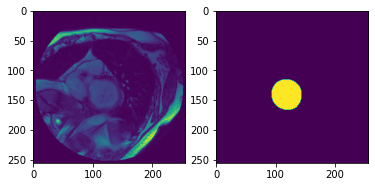

In [ ]:
for idx, contour in enumerate(train_ctrs):
  img, mask, spacing = read_contour(contour, TRAIN_IMG_PATH)
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(img[:,:,0])
  axarr[1].imshow(mask[:,:,0])
  plt.show()
  break

**Plotting proceseed MRI image and Contours**

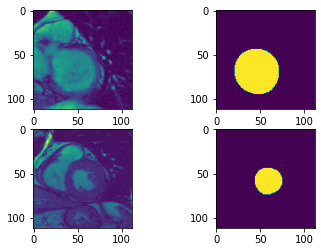

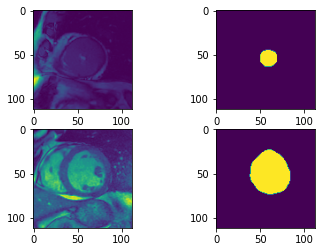

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_train[0,:,:,0])
axarr[0,1].imshow(mask_train[0,:,:,0])
axarr[1,0].imshow(img_train[1,:,:,0])
axarr[1,1].imshow(mask_train[1,:,:,0])
plt.show()

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_vad[2,:,:,0])
axarr[0,1].imshow(mask_vad[2,:,:,0])
axarr[1,0].imshow(img_vad[3,:,:,0])
axarr[1,1].imshow(mask_vad[3,:,:,0])
plt.show()

In [ ]:
print(f"Train image shape {img_train.shape} and Train mask shape {mask_train.shape}")
print(f"Validation image shape {img_vad.shape} and Validation mask shape {mask_vad.shape}")
# print(f"Test image shape {img_test.shape} and Test mask shape {mask_test.shape}")

Train image shape (260, 112, 112, 1) and Train mask shape (260, 112, 112, 1)
Validation image shape (266, 112, 112, 1) and Validation mask shape (266, 112, 112, 1)


**UNET Model**

In [ ]:
# importing all the necessary libraries for UNET
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator,  
from keras_preprocessing.image import img_to_array, array_to_img, img_to_array,load_img
# from tensorflow.keras.utils import img_to_array
from keras.utils.vis_utils import plot_model

**Function to Add 2 convolutional layer to network**

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # adding first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # adding second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

**Defining UNET model**

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)   # convolutional layer
    p1 = MaxPooling2D((2, 2))(c1)                                                         # Max pooling layer
    p1 = Dropout(dropout)(p1)                                                             # Dropout 
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)        # Transposed convolutional layer
    u6 = concatenate([u6, c4])                                                                 # concatenation leyer
    u6 = Dropout(dropout)(u6)                                                                  # Dropout layer
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)               # convolutional layer
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)                                     # applying sigmoid on last layer
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

**Setting parameter for model**

In [ ]:
im_width = 112
im_height = 112
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

**Model Summary**

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 112, 112, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

**Plotting the model**

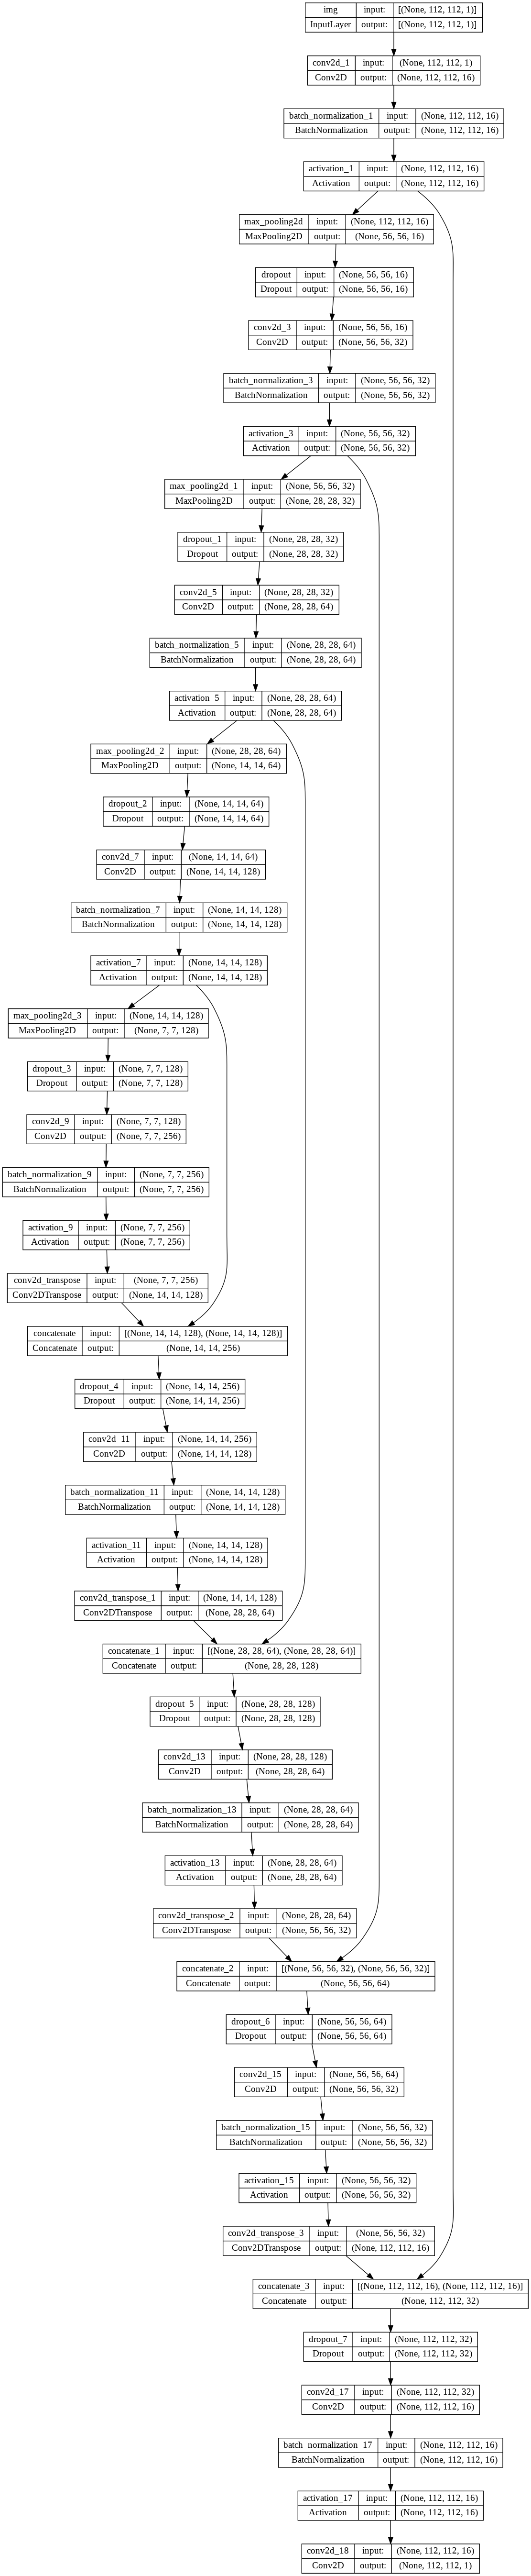

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

**Callback**

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

**Training**

In [ ]:
def Train_function(model, train_images,train_mask, validation_images, validation_maks, batch_size, epoch,callbacks ):
  print("Training ")
  results = model.fit(train_images, train_mask, batch_size=batch_size, epochs=epoch, callbacks=callbacks,\
                    validation_data=(validation_images, validation_maks))
  return results

In [ ]:
epoch = 50
batch_size = 32
results = Train_function(model, img_train, mask_train, img_vad, mask_vad, batch_size, epoch, callbacks)

Training 
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.7192 - accuracy: 0.5805
Epoch 1: val_loss improved from inf to 1.97596, saving model to model-tgs-salt.h5
9/9 [==============================] - 12s 190ms/step - loss: 0.7192 - accuracy: 0.5805 - val_loss: 1.9760 - val_accuracy: 0.3362 - lr: 0.0010
Epoch 2/50
8/9 [=========================>....] - ETA: 0s - loss: 0.5144 - accuracy: 0.8085
Epoch 2: val_loss did not improve from 1.97596
9/9 [==============================] - 1s 65ms/step - loss: 0.5135 - accuracy: 0.8092 - val_loss: 15.5308 - val_accuracy: 0.1228 - lr: 0.0010
Epoch 3/50
8/9 [=========================>....] - ETA: 0s - loss: 0.3637 - accuracy: 0.9423
Epoch 3: val_loss improved from 1.97596 to 1.62376, saving model to model-tgs-salt.h5
9/9 [==============================] - 1s 70ms/step - loss: 0.3630 - accuracy: 0.9425 - val_loss: 1.6238 - val_accuracy: 0.4761 - lr: 0.0010
Epoch 4/50
8/9 [=========================>....] - ETA: 0s - loss: 0.2756 

**Learning Curve**

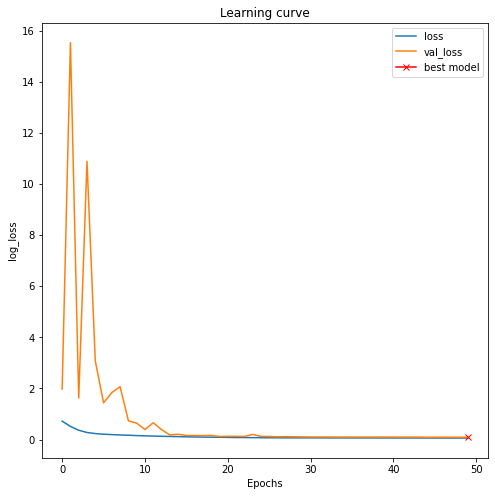

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Function to plot the results**

In [61]:
import random
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))
    print("index is ",ix)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('mask')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('binary mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('predicted mask')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('predicted binary mask');

**Testing**

In [66]:
def Testing(model, test_dict, number_of_patient):
  model.load_weights('model-tgs-salt.h5')
  patient_reach = 0
  for k in test_dict.keys():
    patient_reach +=1
    print("\nTesting patient ", k)
    img_temp, mask_temp , temp_spacing = export_all_contours(test_dict[k], TEST_IMG_PATH, crop_size=crop_size)
    preds_mask = model.predict(img_temp, verbose=1)
    preds_mask_t = (preds_mask > 0.5).astype(np.uint8)
    model.evaluate(mask_temp, preds_mask_t, verbose=1)
    plot_sample(img_temp, mask_temp, preds_mask, preds_mask_t)
    if patient_reach == number_of_patient:
      break
  return results


Testing patient  SC-N-10

Processing 17 images and labels ...

1/1 [==============================] - 0s 31ms/step - loss: 0.2140 - accuracy: 0.9468
index is  14

Testing patient  SC-HF-I-12

Processing 21 images and labels ...

1/1 [==============================] - 0s 34ms/step - loss: 0.2066 - accuracy: 0.9490
index is  3


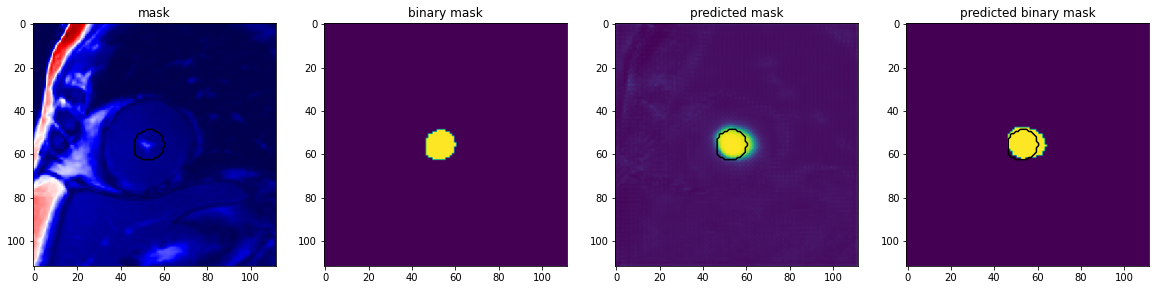

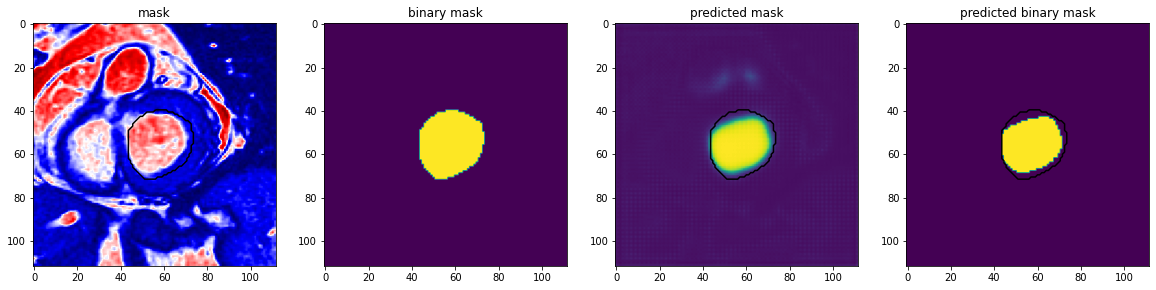

In [67]:
results = Testing(model, sunnybrook_testing_patient_contours, 2)

In [68]:
sunnybrook_testing_patient_contours.keys()

dict_keys(['SC-N-10', 'SC-HF-I-12', 'SC-HF-NI-13', 'SC-HYP-09', 'SC-N-11', 'SC-HF-I-10', 'SC-N-09', 'SC-HF-NI-15', 'SC-HYP-12', 'SC-HF-NI-14', 'SC-HF-I-09', 'SC-HF-NI-12', 'SC-HYP-10', 'SC-HYP-11', 'SC-HF-I-11'])

**Calculating Ejection Fraction**

In [69]:
import cv2
def calc_volume(contours, spacing):
  # Calculate the volume by summing the volumes of each slice
  volume = 0
  i =0
  for (contour, space) in zip(contours, spacing):
  
    # using area 
    temp_contour = contour.astype(np.uint8)
    update_contour, hierarchy = cv2.findContours(temp_contour, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    try:
      cnt = update_contour[0]
      area = cv2.contourArea(cnt)
    # Assume a slice thickness of 1 for the volume calculation
      slice_volume = area * 1
      volume += slice_volume
    
    except:
      print("hello")
      pass
    i+=1

    # # using sapcing
    # contour_volume = np.sum(contour) * space[0] * space[1] * space[2]
    # volume += contour_volume
    
  return volume

def calc_ejection_fraction(contours, spacing):
  # Calculate the left ventricular end-diastolic volume (LVEDV)
  lvedv = calc_volume(contours, spacing)/1000
  # print("lvedv ", lvedv)
  # Calculate the left ventricular end-systolic volume (LVESV)
  lvesv = calc_volume(contours[:len(contours) // 2], spacing)/1000
  # print("lvesv ", lvesv)
  # Check if the LVESV is greater than the LVEDV (which would indicate that the point of maximum contraction occurs before the midpoint of the cardiac cycle)
  if lvesv > lvedv:
    lvesv = calc_volume(contours[len(contours) // 2:], spacing)/1000
  
  # Calculate the ejection fraction
  ejection_fraction = (lvedv - lvesv) / lvedv
  print("EF is ", ejection_fraction)
  return ejection_fraction

**Calculating ejection fraction on orignal contours and predicted contours**

In [74]:
patient_ , orignalEF, EF_ = [], [], []
img_temp, mask_temp , temp_spacing = [], [], []
for k in sunnybrook_testing_patient_contours.keys():
  print("Calculating EF ", k)
  img_temp, mask_temp , temp_spacing = export_all_contours(sunnybrook_testing_patient_contours[k], TEST_IMG_PATH, crop_size=crop_size)
  preds_mask = model.predict(img_temp, verbose=1)
  preds_mask_t = (preds_mask > 0.5).astype(np.uint8)
  model.evaluate(mask_temp, preds_mask_t, verbose=1)
  # plot_results(img_temp, mask_temp, preds_mask)
  # plot_sample(img_temp, mask_temp, preds_mask, preds_mask_t, 0)
  temp_ef = calc_ejection_fraction(preds_mask_t, temp_spacing)
  orignal_ef = calc_ejection_fraction(mask_temp, temp_spacing)
  patient_.append(k)
  EF_.append(temp_ef)
  orignalEF.append(orignal_ef)

Calculating EF  SC-N-10

Processing 17 images and labels ...

1/1 [==============================] - 0s 30ms/step - loss: 0.2140 - accuracy: 0.9468
EF is  0.4172572112985328
EF is  0.41635773864689524
Calculating EF  SC-HF-I-12

Processing 21 images and labels ...

1/1 [==============================] - 0s 35ms/step - loss: 0.2066 - accuracy: 0.9490
hello
hello
hello
hello
EF is  0.5269089327375539
EF is  0.5217491039426524
Calculating EF  SC-HF-NI-13

Processing 20 images and labels ...

1/1 [==============================] - 0s 32ms/step - loss: 0.2898 - accuracy: 0.9241
EF is  0.5608200937048649
EF is  0.4976835982133583
Calculating EF  SC-HYP-09

Processing 16 images and labels ...

1/1 [==============================] - 0s 30ms/step - loss: 0.2546 - accuracy: 0.9348
hello
EF is  0.3647256583767941
EF is  0.36226066897347176
Calculating EF  SC-N-11

Processing 17 images and labels ...

1/1 [==============================] - 0s 33ms/step - loss: 0.2320 - accuracy: 0.9416
EF is  0.60

**Plotting Ejection fraction of orignal contuors and predicted contours**

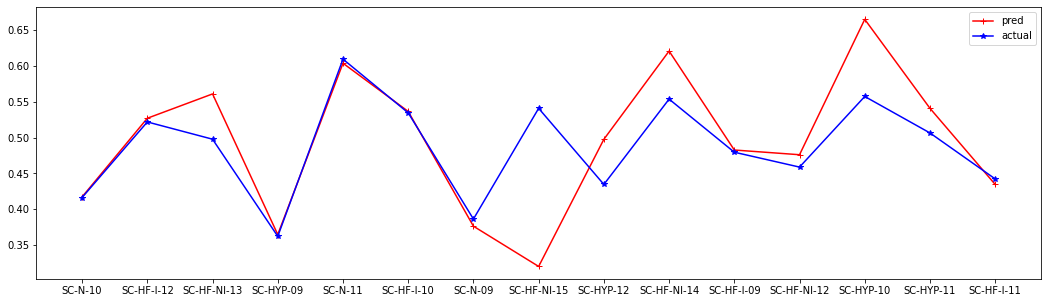

In [75]:
fig, ax = plt.subplots(1, 1, figsize=[18,5])
plt.plot(patient_, EF_, '+', color='r', label="pred", linestyle='-')
plt.plot(patient_, orignalEF, '*', color='b', label="actual", linestyle='-')
plt.legend()